In [1]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time
from datetime import datetime
import csv
import re

2024-07-15 01:17:16.732341: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 01:17:16.734283: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 01:17:16.776952: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 01:17:17.472139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyperparameters
num_epochs = 1
learning_rate = 5e-5
batch_size = 16
num_trains = 15
validation_size = 0.1
label_modularity = "NewClass"
#bert-base-uncased, bert-large-cased
name_model = "bert-base-uncased"

crop_categories = True

In [3]:
#Get documents saved in new categories and their labels
filename = 'FinalDataset/polished_dataset_nosub_67.csv'
name_to_save = "nosub"

data = pd.read_csv(filename)

train_data, validation_data = train_test_split(data, test_size=validation_size, random_state=42)

In [4]:
#GET NUMBER OF LABELS
original_labels = train_data[label_modularity].unique().tolist()
num_labels = num_unique_labels = train_data[label_modularity].nunique()
print(num_labels)

67


In [5]:
# Get total number of texts
num_texts = train_data.shape[0]
print(num_texts)

228933


In [6]:
#Get total number of words
all_text = ' '.join(train_data['Text'].values)
num_words = len(all_text.split())
print(num_words)

19488878


In [7]:
#Count token time
token_start = time.time()

In [8]:
tokenizer = BertTokenizer.from_pretrained(name_model)
train_encodings = tokenizer(list(train_data['Text']), truncation=True, padding=True, max_length=128)

label_encoder = LabelEncoder()
train_data[label_modularity] = label_encoder.fit_transform(train_data[label_modularity])
labels = train_data[label_modularity].tolist()

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    labels
))

2024-07-15 01:21:48.875800: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
val_encodings = tokenizer(list(validation_data['Text']), truncation=True, padding=True, max_length=128)

print(tf.shape(val_encodings['input_ids']))

validation_data[label_modularity] = label_encoder.fit_transform(validation_data[label_modularity])
val_labels = validation_data[label_modularity].tolist()

val_encodings = tf.convert_to_tensor(val_encodings['input_ids'])
val_labels = tf.convert_to_tensor(val_labels)

tf.Tensor([25438   128], shape=(2,), dtype=int32)


In [10]:
token_finish = time.time()

print(token_finish - token_start)

346.05408000946045


In [11]:
train_start = time.time()

In [12]:
model = TFBertForSequenceClassification.from_pretrained(name_model, num_labels=num_labels)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset.batch(batch_size), validation_data=(val_encodings, val_labels), epochs=num_epochs)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-07-15 01:23:10.852429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [228933]
	 [[{{node Placeholder/_3}}]]


14309/14309 [==============================] - 16395s 1s/step - loss: 0.2721 - accuracy: 0.9300 - val_loss: 6.0410 - val_accuracy: 0.4197


In [13]:
train_finish = time.time()

print(train_finish - train_start)

16397.4670484066


In [14]:
val_start = time.time()

In [15]:
val_predictions = model.predict(val_encodings)
val_predictions = np.argmax(val_predictions.logits, axis=1)

precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
f1 = f1_score(val_labels, val_predictions, average='weighted')
acc = history.history['val_accuracy'][-1]

print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

with open('Results/results_2Data_'+name_model+'.txt', 'a') as file:
    file.write(f'Accuracy: {acc}\n')
    file.write(f'Precision: {precision}\n')
    file.write(f'Recall: {recall}\n')
    file.write(f'F1: {f1}\n')

795/795 [==============================] - 405s 506ms/step
Accuracy: 0.41968709230422974
Precision: 0.41662120694173366
Recall: 0.4196870823177923
F1: 0.4177279873599643


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
val_finish = time.time()

print(val_finish - val_start)

405.6852333545685


In [17]:
#Save results
csv_file = "Results/ModelResults.csv"
current_date = datetime.now().strftime('%Y-%m-%d')

with open(csv_file, mode='a', newline='') as file:
    writer = csv.writer(file)

    # Escribir los nombres de las columnas en la primera fila
    if file.tell() == 0:  # Verificar si el archivo está vacío
        writer.writerow(column_names)
    
    # Escribir los valores en una nueva fila
    writer.writerow(["BERT", num_labels, num_texts, num_words, acc, precision, f1, recall, train_finish - train_start, val_finish - val_start, current_date, name_to_save])

Confusion Matrix:
[[2236    0    0 ...    1    0    0]
 [   0  271    0 ...    0    0    0]
 [   0    0   12 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  731]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


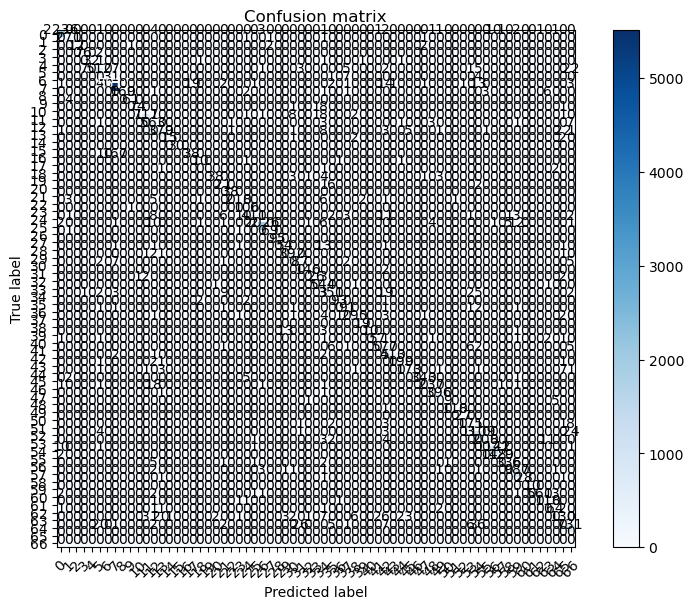

In [18]:
conf_matrix = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(conf_matrix)

#Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(set(labels)))
plt.xticks(tick_marks, set(labels), rotation=45)
plt.yticks(tick_marks, set(labels))

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

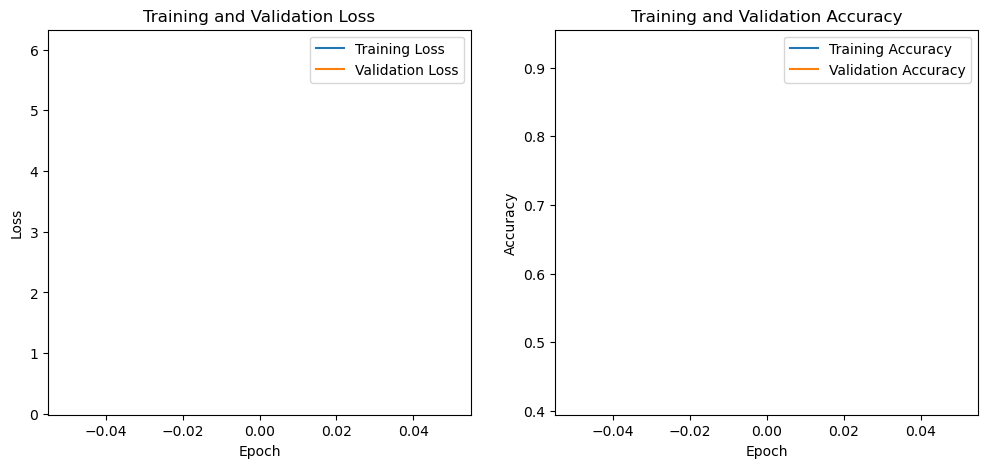

In [19]:
#Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
#Get accuracy of every class
class_accuracy = {}
for i in range(len(label_encoder.classes_)):
    class_name = label_encoder.classes_[i]
    total = conf_matrix[i].sum()
    correct = conf_matrix[i][i]
    accuracy = correct / total if total > 0 else 0.0
    class_accuracy[class_name] = accuracy

sorted_class_accuracy = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)

print("Accuracy por clase:")
for class_name, acc in sorted_class_accuracy:
    print(f"{class_name}: {acc}")

# Calcular el accuracy general
accuracy = accuracy_score(val_labels, val_predictions)
print("Accuracy general:", accuracy)

Accuracy por clase:
Cheese: 1.0
Athlete: 0.9887076537013801
Album: 0.98719646799117
Animal: 0.9854545454545455
Architect: 0.9743589743589743
Book: 0.9706896551724138
BodyOfWater: 0.9676113360323887
Bacteria: 0.9384615384615385
Automobile: 0.9234972677595629
Artist: 0.9061946902654867
Building: 0.8959810874704491
Beach: 0.8705882352941177
Artery: 0.8648648648648649
Cave: 0.75
Archaea: 0.7058823529411765
Astronaut: 0.1875
OlympicResult: 0.01182033096926714
MilitaryPerson: 0.007556675062972292
Film: 0.000964785335262904
Coach: 0.0
Colour: 0.0
Company: 0.0
Country: 0.0
Criminal: 0.0
Currency: 0.0
Disease: 0.0
Drug: 0.0
FictionalCharacter: 0.0
Fungus: 0.0
Galaxy: 0.0
Holiday: 0.0
Island: 0.0
Journalist: 0.0
Language: 0.0
Locality: 0.0
MilitaryConflict: 0.0
Mineral: 0.0
Model: 0.0
Mountain: 0.0
Muscle: 0.0
MusicFestival: 0.0
MusicGenre: 0.0
Noble: 0.0
Painting: 0.0
Park: 0.0
Plant: 0.0
Play: 0.0
PoliticalParty: 0.0
ProgrammingLanguage: 0.0
Protein: 0.0
Referee: 0.0
Religious: 0.0
Scientist: 

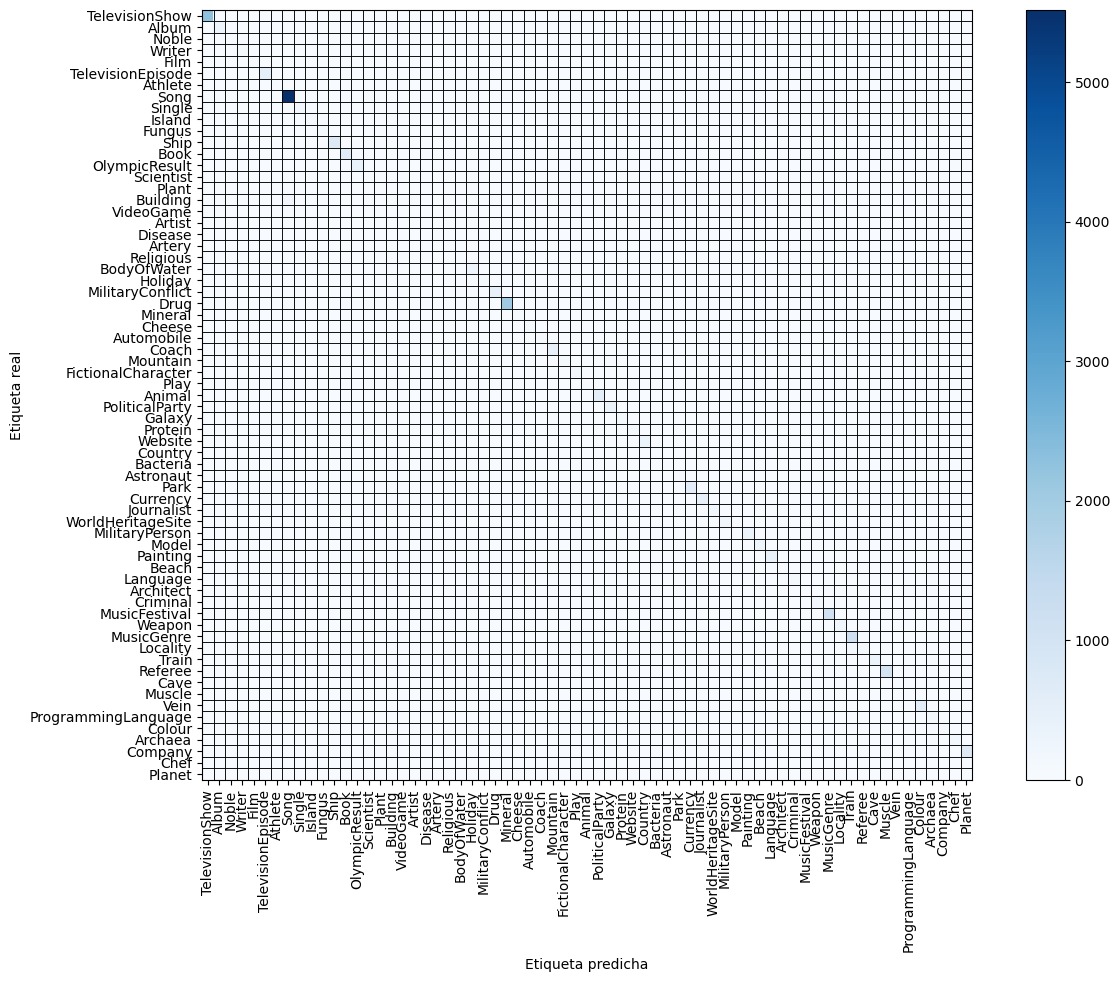

In [21]:
cmap=plt.cm.Blues

plt.figure(figsize=(14, 10))
plt.title("")

plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(num_labels)
plt.xticks(tick_marks, original_labels, rotation=90)
plt.yticks(tick_marks, original_labels)

for i in range(num_labels):
        for j in range(num_labels):
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='black', fill=None, linewidth=0.5))

plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta real')
plt.show()

In [22]:
model.save("Models/"+name_model+"_model")

2024-07-15 06:03:26.831135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'attention_mask' with dtype int32 and shape [?,?]
	 [[{{node attention_mask}}]]
2024-07-15 06:03:28.541849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'attention_mask' with dtype int32 and shape [?,?]
	 [[{{node attention_mask}}]]
2024-07-15 06:03:28.679380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_ids_1' with dtype int32 and shape [?,?]
	 [[{{n

INFO:tensorflow:Assets written to: Models/bert-base-uncased_model/assets


INFO:tensorflow:Assets written to: Models/bert-base-uncased_model/assets
